# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [4]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [9]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH, list_datasets
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [10]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [11]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

In [12]:
list_datasets(context)

['/raw/sales',
 '/raw/google_search',
 '/raw/social_media',
 '/raw/product_manufacturer_list',
 '/raw/Theme_product_list',
 '/raw/Theme_list',
 '/processed_data/sales',
 '/processed_data/google_search',
 '/processed_data/social_media',
 '/processed_data/product_manufacturer_list',
 '/processed_data/Theme_product_list',
 '/processed_data/Theme_list',
 '/merged_data/sales',
 '/merged_data/google_search',
 '/merged_data/social_media',
 '/merged_data/product_manufacturer_list',
 '/merged_data/Theme_product_list',
 '/merged_data/Theme_list',
 '/ground_truth_for_modelling/ground_truth',
 '/train/ground_truth_for_modelling/features',
 '/train/ground_truth_for_modelling/target',
 '/test/ground_truth_for_modelling/features',
 '/test/ground_truth_for_modelling/target']

In [40]:
ground_truth_for_modelling = load_dataset(context, '/ground_truth_for_modelling/ground_truth')

#### Preliminary checks before modelling

In [42]:
# No missing values
ground_truth_for_modelling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                420 non-null    int64  
 1   date                      420 non-null    object 
 2   theme_name                420 non-null    object 
 3   total_post                420 non-null    int64  
 4   google_searchVolume       420 non-null    float64
 5   amazon_searchVolume       420 non-null    float64
 6   chewy_searchVolume        420 non-null    float64
 7   walmart_searchVolume      420 non-null    float64
 8   total_searchVolume        420 non-null    float64
 9   client_lbs_value          420 non-null    float64
 10  client_units_value        420 non-null    int64  
 11  client_dollars_value      420 non-null    float64
 12  competitor_lbs_value      420 non-null    float64
 13  competitor_units_value    420 non-null    int64  
 14  competitor

In [43]:
# Creating variables for price of client and competitor
ground_truth_for_modelling['client_unit_price'] = ground_truth_for_modelling['client_dollars_value'] / ground_truth_for_modelling['client_units_value']
ground_truth_for_modelling['competitor_unit_price'] = ground_truth_for_modelling['competitor_dollars_value'] / ground_truth_for_modelling['competitor_units_value']

In [46]:
ground_truth_for_modelling

,Unnamed: 0,date,theme_name,total_post,google_searchVolume,amazon_searchVolume,chewy_searchVolume,walmart_searchVolume,total_searchVolume,client_lbs_value,client_unit_price,competitor_unit_price
0,0,2016-01-09,salmon,47,1913.0,0.0,0.0,0.0,1913.0,5.379338e+06,10.120685,7.451236
1,42,2016-02-06,salmon,47,850.0,0.0,0.0,0.0,850.0,5.217845e+06,9.974540,7.736047
2,84,2016-02-20,salmon,156,1063.0,0.0,0.0,0.0,1063.0,4.747996e+06,9.932648,7.407171
3,126,2016-02-27,salmon,90,1912.0,0.0,0.0,0.0,1912.0,4.676554e+06,9.879768,7.430647
4,168,2016-03-26,salmon,50,1912.0,0.0,0.0,0.0,1912.0,4.739258e+06,9.697814,7.526944
...,...,...,...,...,...,...,...,...,...,...,...,...
415,17430,2019-09-07,low carb,1891,38008.0,5236.0,4489.0,627.0,48360.0,4.028791e+06,4.940891,7.081531
416,17472,2019-09-14,low carb,1142,41306.0,4655.0,4862.0,669.0,51492.0,4.017835e+06,4.948014,7.032547
417,17514,2019-09-21,low carb,1158,35338.0,3699.0,2952.0,625.0,42614.0,3.974981e+06,4.970951,7.107041
418,17556,2019-09-28,low carb,1545,33610.0,6315.0,2661.0,960.0,43546.0,3.980566e+06,4.850479,7.114048


In [65]:
ground_truth_for_modelling.drop(columns=['Unnamed: 0'], inplace=True)


KeyError: "['Unnamed: 0'] not found in axis"

In [74]:

numerical_features = ground_truth_for_modelling.select_dtypes(include='number')

features = X = ground_truth_for_modelling.drop(columns=['client_lbs_value'])
target = y = ground_truth_for_modelling['client_lbs_value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


save_dataset(context, X_train, '/train/ground_truth_for_modelling/features')
save_dataset(context, y_train, '/train/ground_truth_for_modelling/target')

save_dataset(context, X_test, '/test/ground_truth_for_modelling/features')
save_dataset(context, y_test, '/test/ground_truth_for_modelling/target')

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [51]:
# collecting different types of columns for transformations
cat_columns = X_train.select_dtypes('object').columns
num_columns = X_train.select_dtypes('number').columns

In [52]:
cat_columns

Index(['date', 'theme_name'], dtype='object')

In [53]:
num_columns

Index(['total_post', 'google_searchVolume', 'amazon_searchVolume',
       'chewy_searchVolume', 'walmart_searchVolume', 'total_searchVolume',
       'client_unit_price', 'competitor_unit_price'],
      dtype='object')

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [54]:
# In our case, there were no significant outliers. Hence we would be skipping this step.

#### Encoding

Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

In [55]:
def one_hot_encode_column(dataframe, cat_variable):
    one_hot = pd.get_dummies(dataframe[cat_variable], drop_first=True)
    # Drop column B as it is now encoded
    dataframe = dataframe.drop('theme_name',axis = 1) # Join the encoded df
    dataframe = dataframe.join(one_hot)
    return dataframe

In [75]:
def engineer_date_related_features(dataframe):
    temp_dataframe = dataframe.copy()
    temp_dataframe['date'] = pd.to_datetime(temp_dataframe['date'])
    temp_dataframe['year'] = temp_dataframe['date'].dt.year
    temp_dataframe['month'] = temp_dataframe.date.dt.month
    temp_dataframe['quarter'] = temp_dataframe.date.dt.quarter
    temp_dataframe.drop(columns=['date'], inplace=True)
    return temp_dataframe

In [76]:
train_one_hot_encoder_transformer = FunctionTransformer(one_hot_encode_column, kw_args={'cat_variable': 'theme_name'})
test_one_hot_encoder_transformer = FunctionTransformer(one_hot_encode_column, kw_args={'cat_variable': 'theme_name'})
date_feature_generator = FunctionTransformer(engineer_date_related_features)

In [77]:
feature_engineering_pipeline_train = Pipeline([('one_hot_encoding', train_one_hot_encoder_transformer)
                                               , ('date_feature_generator', date_feature_generator)])
feature_engineering_pipeline_test = Pipeline([('one_hot_encoding', test_one_hot_encoder_transformer)
                                               , ('date_feature_generator', date_feature_generator)])

In [78]:
X_train = feature_engineering_pipeline_train.fit_transform(X_train)
X_test = feature_engineering_pipeline_train.fit_transform(X_test)

**Dev notes(Encoding):**
<details>

    Some common practices followed in Categorical Feature Encoding are
    * For categorical variables with too many levels, target encoding can be done.
    * For fewer levels, one hot encoding can be done.
    * If one very dominant level is observed, binary encoding can be used.
    
    
</details>

## 3.2 Feature analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [81]:
out = eda.get_density_plots(X_train, cols=X_train.columns.tolist())
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [total_post]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [86]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

In [84]:
reports.feature_analysis(X_train,'./feature_analysis_report.html')

### 3.2.2 Bivariate - mutual interactions

In [88]:
out = eda.get_correlation_table(X_train)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,google_searchVolume,total_searchVolume,0.980857,0.980857
1,month,quarter,0.969128,0.969128
2,client_unit_price,salmon,0.961042,0.961042
3,amazon_searchVolume,walmart_searchVolume,0.932282,0.932282
4,amazon_searchVolume,chewy_searchVolume,0.929808,0.929808
5,chewy_searchVolume,walmart_searchVolume,0.910006,0.910006
6,competitor_unit_price,salmon,-0.808477,0.808477
7,client_unit_price,google_searchVolume,-0.753799,0.753799
8,client_unit_price,total_searchVolume,-0.738314,0.738314
9,google_searchVolume,salmon,-0.736755,0.736755


In [89]:
# Check for multicollinearity
# We will remove variables that have VIF greater than 10 except key features like client_unit_price, competitor_unit_price
# and total_post
# Dropping total search volume as its highly correlated with google search volume
# Dropping chewy search volume as its highly correlated with amazon search volume
# We will be going forward with the rest of the features as they represent key 
# features to account for after the modelling stage(despite the high correlations).
columns_to_drop = ['chewy_searchVolume', 'total_searchVolume']
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

In [90]:
out = eda.get_correlation_table(X_train)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,month,quarter,0.969128,0.969128
1,client_unit_price,salmon,0.961042,0.961042
2,amazon_searchVolume,walmart_searchVolume,0.932282,0.932282
3,competitor_unit_price,salmon,-0.808477,0.808477
4,client_unit_price,google_searchVolume,-0.753799,0.753799
5,google_searchVolume,salmon,-0.736755,0.736755
6,client_unit_price,competitor_unit_price,-0.724347,0.724347
7,competitor_unit_price,no additives/preservatives,0.637393,0.637393


In [91]:
out = eda.get_bivariate_plots(X_train, x_cols=['salmon'], y_cols=['no additives/preservatives'])
out

:Bars   [salmon,no additives/preservatives]   (count)

In [96]:
%%time
# create reports as needed
cols = X_train.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(X_train, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 5.07 s, sys: 12.4 ms, total: 5.08 s
Wall time: 5.06 s


In [97]:
reports.feature_interactions(X_train,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [102]:
out = eda.get_target_correlation(X_train, y_train, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
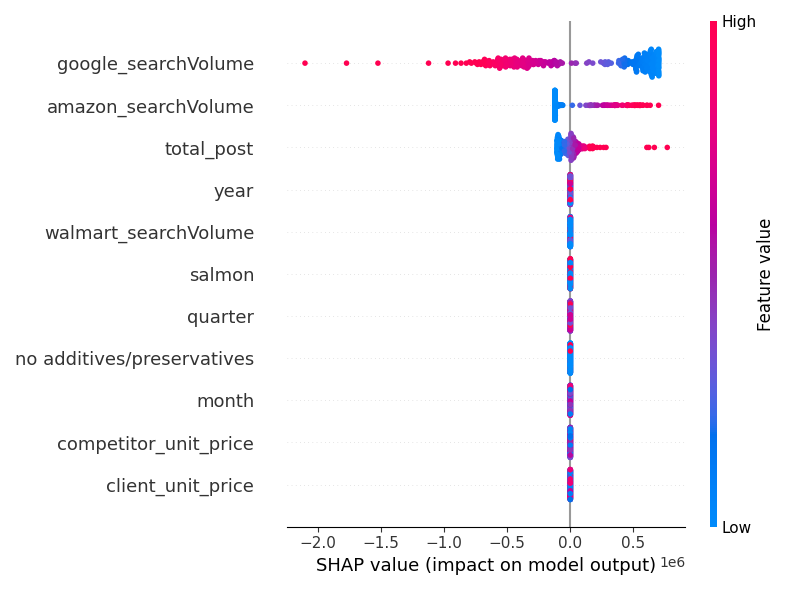

In [103]:
out = eda.get_feature_importances(X_train, y_train, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

In [104]:
reports.key_drivers(X_train,y_train, './key_drivers_report.html', y_continuous=True)

Error: 'Series' object has no attribute 'columns'

In [106]:
reports.data_exploration(X_train,y_train,'./data_exploration_report.html', y_continuous=True)

Error: 'Series' object has no attribute 'columns'

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [110]:
reg_vars = X_train.columns.tolist()

In [111]:
X_train = X_train[reg_vars]
X_test = X_test[reg_vars]

### 4.1.2 Data transformations

In [112]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [132]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(X_train, y_train)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

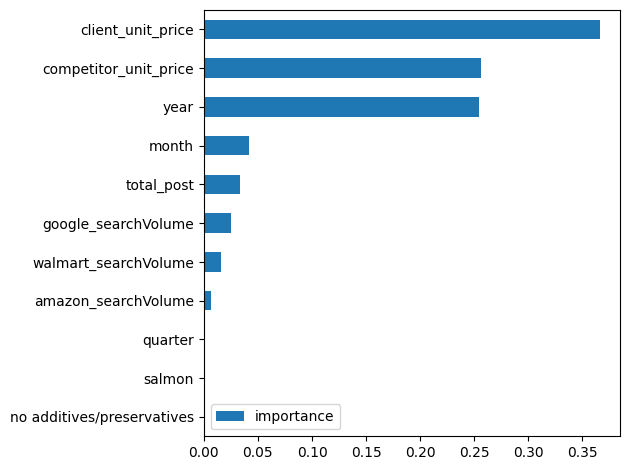

In [134]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = X_train.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'client_unit_price','competitor_unit_price','total_post','google_searchVolume' are considered to be important and in grid search

In [135]:
imp_features = ['client_unit_price', 'competitor_unit_price', 'total_post'
                , 'google_searchVolume']

In [113]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(X_train, y_train.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa4dde5c700>,
                                     kw_args={'cols2keep': ['total_post',
                                                            'google_searchVolume',
                                                            'amazon_searchVolume',
                                                            'walmart_searchVolume',
                                                            'client_unit_price',
                                                            'competitor_unit_price',
                                                            'no '
                                                            'additives/preservatives',
                                                            'salmon', 'year',
                                                            'month',
                                                            'quarter']})),
                ('estimator', SKLStatsmodelOLS())])

In [114]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     142.4
Date:                Sun, 11 Jun 2023   Prob (F-statistic):          3.41e-108
Time:                        21:13:32   Log-Likelihood:                -4164.2
No. Observations:                 294   AIC:                             8352.
Df Residuals:                     282   BIC:                             8397.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                  -5.633e+08   8.62e+07     -6.534      0.000   -7.33e+08   -3.94e+08
total_post                    29.2282     13.904      2.102      0.036       1.860      56.596
google_searchVolume           -6.1720      2.395     -2.577      0.010     -10.886      -1.458
amazon_searchVolume           41.4647     14.808      2.800      0.005      12.317      70.612
walmart_searchVolume         -20.3472    110.775     -0.184      0.854    -238.399     197.704
client_unit_price          -2.297e+05   5.13e+04     -4.480      0.000   -3.31e+05   -1.29e+05
competitor_unit_price       1.405e+05   5.77e+04      2.435      0.016    2.69e+04    2.54e+05
no additives/preservatives -9.265e+05   1.75e+05     -5.297      0.000   -1.27e+06   -5.82e+05
salmon                      2.781e+06    3.7e+05      7.510      0.000    2.05e+06    3.51e+06
year                        2.811e+05   4.27e+04      6.581      0.000    1.97e+05    3.65e+05
month                       9.011e+04   2.48e+04      3.627      0.000    4.12e+04    1.39e+05
quarter                     -1.14e+05   7.77e+04     -1.467      0.143   -2.67e+05    3.89e+04
==============================================================================
Omnibus:                       10.928   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.107
Skew:                           0.463   Prob(JB):                      0.00387
Kurtosis:                       3.218   Cond. No.                     1.39e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [115]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])


In [116]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=X_train, y_train=y_train, x_test= X_test, y_test= y_test, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [123]:
threshold=0.3
residual_analysis = X_test.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(X_test)
residual_analysis['actuals'] = y_test.values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [124]:
residual_analysis.hvplot.kde(y="client_unit_price",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="unit_lbs_value",
                                title=f'unit lbs(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [client_unit_price]   (Density)

### 4.1.6 Model Evaluation(Decision Tree)

In [129]:
%%time
parameters = {
   'max_features':[5],
   'min_samples_split':[2, 5],
   'max_depth':[3, 5],
   'ccp_alpha': [0.3, 0.5]
}
est = DecisionTreeRegressor()
dtreg_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

dtreg_grid.fit(X_train, y_train)

print(dtreg_grid.best_score_)
print(dtreg_grid.best_params_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
0.8796635524234463
{'ccp_alpha': 0.3, 'max_depth': 5, 'max_features': 5, 'min_samples_split': 5}
CPU times: user 78.5 ms, sys: 250 ms, total: 329 ms
Wall time: 2.06 s


In [136]:
decision_tree = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('Decision Tree', dtreg_grid.best_estimator_)
])
decision_tree.fit(X_train, y_train)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa4dde5c700>,
                                     kw_args={'cols2keep': ['client_unit_price',
                                                            'competitor_unit_price',
                                                            'total_post',
                                                            'google_searchVolume']})),
                ('Decision Tree',
                 DecisionTreeRegressor(ccp_alpha=0.3, max_depth=5,
                                       max_features=5, min_samples_split=5))])

In [137]:
decision_tree_report = RegressionReport(model=decision_tree, x_train=X_train, y_train=y_train, x_test= X_test, y_test= y_test, refit=True)
decision_tree_report.get_report(include_shap=False, file_path='decision_tree_report')

### 4.1.7 Model Evaluation(Random Forest)

In [138]:
%%time
parameters = {
   'n_estimators':[100, 200, 300],
   'min_samples_split':[2, 5],
   'max_depth':[3, 5],
   'ccp_alpha': [0.3, 0.5],
   'bootstrap': [True, False]
}
est = RandomForestRegressor()
rf_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

rf_grid.fit(X_train, y_train)

print(rf_grid.best_score_)
print(rf_grid.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
0.9111167895698797
{'bootstrap': True, 'ccp_alpha': 0.3, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
CPU times: user 478 ms, sys: 114 ms, total: 592 ms
Wall time: 4.93 s


In [139]:
random_forest = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('Random Forest', rf_grid.best_estimator_)
])
random_forest.fit(X_train, y_train)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa4dde5c700>,
                                     kw_args={'cols2keep': ['client_unit_price',
                                                            'competitor_unit_price',
                                                            'total_post',
                                                            'google_searchVolume']})),
                ('Decision Tree',
                 RandomForestRegressor(ccp_alpha=0.3, max_depth=5,
                                       n_estimators=200))])

In [140]:
rf_report = RegressionReport(model=random_forest, x_train=X_train, y_train=y_train, x_test= X_test, y_test= y_test, refit=True)
rf_report.get_report(include_shap=False, file_path='random_forest_report')

### 4.1.8 Model Evaluation(XGBoost)

In [ ]:
%%time
parameters = {
   'n_estimators':[100],
   'min_samples_split':[5],
   'bootstrap': [True, False]
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [139]:
xgboost = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgboost.fit(X_train, y_train)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa4dde5c700>,
                                     kw_args={'cols2keep': ['client_unit_price',
                                                            'competitor_unit_price',
                                                            'total_post',
                                                            'google_searchVolume']})),
                ('Decision Tree',
                 RandomForestRegressor(ccp_alpha=0.3, max_depth=5,
                                       n_estimators=200))])

In [140]:
rf_report = RegressionReport(model=random_forest, x_train=X_train, y_train=y_train, x_test= X_test, y_test= y_test, refit=True)
rf_report.get_report(include_shap=False, file_path='random_forest_report')

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [ ]:
model_pipelines = [reg_ppln, xgb_pipeline_final]
model_comparison_report = RegressionComparison(models=model_pipelines,x=train_X, y=train_y)
metrics = model_comparison_report.get_report(file_path='regression_comparison')

# TODO : Include gridsearchCV for all models

model_comparison_report.performance_metrics

A report comparing the performance, metrics between Linear model and Tree model are available [here](https://drive.google.com/file/d/1LDibiFap9K4DKME-Y0S0mtI_05lTdaJF/view?usp=sharing)

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges